In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import h5py
from patchify import patchify  # only to handle large images
from scipy import ndimage

# 读取数据集，进行预处理和健全性检查

In [2]:
# 数据路径
data_dir = "./data/"
# 读取数据列表
list_path = "./data/train.txt"
# 获取数据列表
img_ids = [i_id.strip() for i_id in open(list_path)]

all_images = []
all_labels = []

# 遍历数据路径列表，读取每个H5文件
for path in img_ids:
    label_path = path.replace("img", "mask").replace("image", "mask")
    # 获取数据集保存的名称
    # dataset_names = list(file.keys())
    # 使用h5py打开文件
    with h5py.File(data_dir + path, "r") as f:
        # 读取图像数据并转换为NumPy数组
        image = f["img"][:]
        all_images.append(image)
    with h5py.File(data_dir + label_path, "r") as f:
        # 读取标签数据并转换为NumPy数组
        label = f["mask"][:]
        all_labels.append(label)

# 将列表转换为NumPy数组
images = np.array(all_images)
labels = np.array(all_labels)
print(images.shape)
print(labels.shape)

(3799, 128, 128, 14)
(3799, 128, 128)


去掉掩膜中全部为空的样本

In [3]:
# 去掉掩膜中全部为空的样本
valid_images = [i for i, mask in enumerate(labels) if mask.max() != 0]
# 仅保留有效样本
filtered_images = images[valid_images]
filtered_labels = labels[valid_images]
print(filtered_images.shape)
print(filtered_labels.shape)

(2231, 128, 128, 14)
(2231, 128, 128)


对数据集进行分层归一化

In [7]:
stack_images = np.stack(filtered_images)
# 计算全局均值和标准差
mean = np.mean(stack_images, axis=(0, 1, 2))
std = np.std(stack_images, axis=(0, 1, 2))
# 输出均值和标准差以验证
print("Mean of the images:", mean)
print("Standard deviation of the images:", std)
# 归一化图像
normalized_images = (stack_images - mean) / std
# normalized_stack_images = [(img - mean) / std for img in filtered_images]
# 如果需要将归一化的图像列表转换回NumPy数组
# normalized_images = np.stack(normalized_stack_images)

Mean of the images: [0.89603465 0.89020885 0.92852416 0.9486672  1.02401986 1.03270346
 1.02203472 1.03941631 1.23838969 1.23608923 1.05726793 1.04990226
 1.46617787 1.94618911]
Standard deviation of the images: [0.12454451 0.20489878 0.30908484 0.57073069 0.46165143 0.4270798
 0.44247123 0.47738594 0.50321661 0.80072613 0.52820076 0.66987501
 0.58265616 1.01596085]


关联切片和样本，方便调用

In [10]:
dataset_dict = {}

# 遍历图像和标签的索引
for i in range(len(normalized_images)):
    dataset_dict[i] = {
        'image': normalized_images[i],
        'label': filtered_labels[i]
    }
# dataset_dict

随机选取图像和样本显示

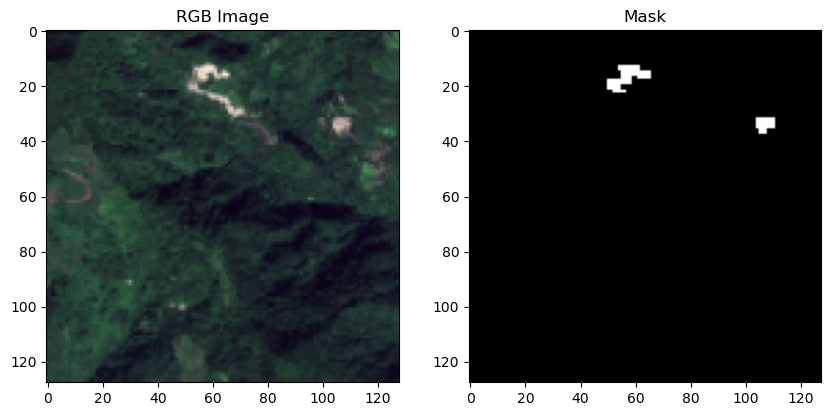

In [21]:
img_num = random.randint(0, len(filtered_images) - 1)
example_img = dataset_dict[img_num]["image"]
example_mask = dataset_dict[img_num]["label"]

# 假设example_img的形状是 (高, 宽, 通道)
# 确定通道索引，Python是从0开始索引的
r_channel = 3  # 第4通道
g_channel = 2  # 第3通道
b_channel = 1  # 第2通道

# 提取RGB通道
rgb_img = np.stack([example_img[:,:,r_channel],
                    example_img[:,:,g_channel],
                    example_img[:,:,b_channel]], axis=2)

# 如果图像数据是浮点型，归一化到[0, 1]
if rgb_img.dtype == np.float32 or rgb_img.dtype == np.float64:
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

# 如果图像数据是整数型，但范围不在[0, 255]，重新缩放到[0, 255]
elif rgb_img.dtype == np.uint8:
    rgb_img = np.clip(rgb_img, 0, 255)  # 用np.clip确保值在0到255之间
else:
    # 对于其他整数类型，归一化到[0, 255]
    rgb_img = 255 * (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    rgb_img = rgb_img.astype(np.uint8)

# 绘制RGB图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(rgb_img)

# 绘制掩码，假设掩码是单通道
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(example_mask, cmap='gray')  # 使用灰度颜色映射

# 显示图表
plt.show()

从mask中获取边界框

In [22]:
# 从mask中获取边界框
def get_bounding_box(ground_truth_map):
    # get the bounding box of the mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates 增加扰动
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 10))
    x_max = min(W, x_max + np.random.randint(0, 10))
    y_min = max(0, y_min - np.random.randint(0, 10))
    y_max = min(H, y_max + np.random.randint(0, 10))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox


创建SAM数据实例

In [23]:
from torch.utils.data import Dataset
class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        ground_truth_mask = item['label']
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        #  remove batch dimension which the processor adds by default
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs
    

In [24]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [25]:
# create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset_dict, processor=processor)

example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)

ValueError: Unable to infer channel dimension format